# Sign Language Detection System

**Importing the Necessary Libaries**

In [45]:
# 1. Importing all necessary libraries

# Basic
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Image handling
import cv2
from tensorflow.keras.utils import to_categorical, img_to_array, load_img



# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models ,regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Model utilities
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# System
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")
print("TensorFlow version:", tf.__version__)


✅ Libraries imported successfully
TensorFlow version: 2.18.0


**Dataset Setup**

Number of train classes: 29
Train Classes: ['N', 'R', 'space', 'B', 'I', 'del', 'F', 'H', 'E', 'U'] ...
Number of images in class A: 3000


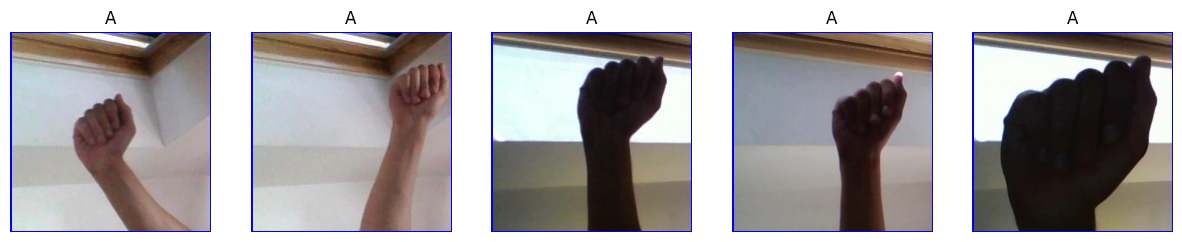

Number of test images: 28
First 10 test images: ['A_test.jpg', 'E_test.jpg', 'L_test.jpg', 'N_test.jpg', 'S_test.jpg', 'D_test.jpg', 'G_test.jpg', 'I_test.jpg', 'W_test.jpg', 'M_test.jpg']


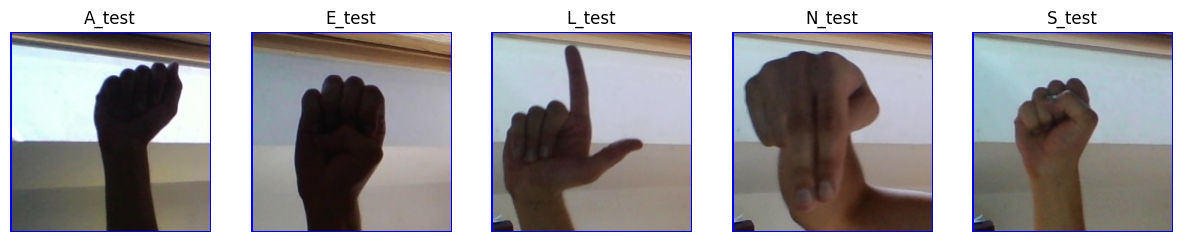

In [2]:
# 2. Dataset Path Setup & Preview

# Train and Test directories (go one level deeper because of nesting)
train_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
test_dir  = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"

# ----------------------
# TRAINING SET
# ----------------------
classes = os.listdir(train_dir)
print("Number of train classes:", len(classes))
print("Train Classes:", classes[:10], "...")

# Preview a few images from class 'A'
sample_class = 'A'
sample_path = os.path.join(train_dir, sample_class)
print(f"Number of images in class {sample_class}:", len(os.listdir(sample_path)))

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, img_name in enumerate(os.listdir(sample_path)[:5]):
    img_path = os.path.join(sample_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title(sample_class)
plt.show()


# ----------------------
# TEST SET
# ----------------------
test_images = os.listdir(test_dir)
print("Number of test images:", len(test_images))
print("First 10 test images:", test_images[:10])

# Preview first 5 test images
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, img_name in enumerate(test_images[:5]):
    img_path = os.path.join(test_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title(img_name.split('.')[0])
plt.show()


**Preprocessing Data**

In [49]:
# 3. Data Preprocessing

IMG_SIZE = 64  # Resize all images to 64x64
num_classes = len(classes)

def load_and_preprocess(img_path):
    """Load an image, resize, normalize, and convert to array."""
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize [0,1]
    return img_array

# ----------------------
# LOAD TRAIN DATA
# ----------------------
X, y = [], []
for idx, label in enumerate(classes):
    folder_path = os.path.join(train_dir, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        X.append(load_and_preprocess(img_path))
        y.append(idx)

X = np.array(X)
y = np.array(y)

print("Train data shape:", X.shape)
print("Train labels shape:", y.shape)

# One-hot encode labels
y = to_categorical(y, num_classes=num_classes)
print("After one-hot encoding:", y.shape)

# ----------------------
# LOAD TEST DATA
# ----------------------
X_test, y_test_labels = [], []
for img_name in test_images:  
    img_path = os.path.join(test_dir, img_name)
    X_test.append(load_and_preprocess(img_path))
    
    # Label comes from file name prefix (e.g., "A_test.jpg" → "A")
    label = img_name.split('_')[0]
    y_test_labels.append(classes.index(label))

X_test = np.array(X_test)
y_test = to_categorical(y_test_labels, num_classes=num_classes)

print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)


Train data shape: (87000, 64, 64, 3)
Train labels shape: (87000,)
After one-hot encoding: (87000, 29)
Test data shape: (28, 64, 64, 3)
Test labels shape: (28, 29)


**Data Spliting**

In [50]:
# First split into train (70%) and temp (30% for val+test)
x_train, x_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Now split temp equally into validation (15%) and test (15%)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("Train shape:", x_train.shape, y_train.shape)
print("Validation shape:", x_val.shape, y_val.shape)
print("Test shape:", x_test.shape, y_test.shape)

Train shape: (60900, 64, 64, 3) (60900, 29)
Validation shape: (13050, 64, 64, 3) (13050, 29)
Test shape: (13050, 64, 64, 3) (13050, 29)


**Model Building CNN**

In [51]:
input_shape = (64, 64, 3)

model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    
    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    # Global pooling instead of flatten
    GlobalAveragePooling2D(),
    
    # Dense layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,909 (448.86 KB)

 Trainable params: 114,205 (446.11 KB)

 Non-trainable params: 704 (2.75 KB)

In [27]:
print(y_train.shape)
print(y_val.shape)

(30450, 29)
(6525, 29)


**Model Training**

In [52]:
# 6. Model Training

class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.90, filepath="sign_language_model.keras"):
        super().__init__()
        self.threshold = threshold
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= self.threshold:
            print(f"\n✅ Reached {self.threshold*100:.0f}% validation accuracy. "
                  f"Saving model to {self.filepath} and stopping training.")
            self.model.save(self.filepath)
            self.model.stop_training = True

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
acc_stop   = AccuracyThresholdCallback(threshold=0.90, filepath="sign_language_model.keras")

# Train
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, reduce_lr, acc_stop]
)

# Final evaluation
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


Epoch 1/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.4075 - loss: 2.0629 - val_accuracy: 0.8037 - val_loss: 0.6263 - learning_rate: 0.0010
Epoch 2/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9078 - loss: 0.2996 - val_accuracy: 0.8366 - val_loss: 0.4845 - learning_rate: 0.0010
Epoch 3/50
948/952 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9577 - loss: 0.1364
✅ Reached 90% validation accuracy. Saving model to sign_language_model.keras and stopping training.
952/952 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9577 - loss: 0.1363 - val_accuracy: 0.9234 - val_loss: 0.2320 - learning_rate: 0.0010
Validation Accuracy: 0.9234
Validation Loss: 0.2320


**Accuracy**

In [53]:
import sys
import tensorflow as tf
import cv2
import PIL
import numpy as np
import pandas as pd
import matplotlib
import sklearn

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("OpenCV:", cv2.__version__)
print("Pillow:", PIL.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Scikit-learn:", sklearn.__version__)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.18.0
OpenCV: 4.11.0
Pillow: 11.2.1
NumPy: 1.26.4
Pandas: 2.2.3
Matplotlib: 3.7.2
Scikit-learn: 1.2.2
